In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from functools import reduce as func_reduce
from operator import mul as op_mul

#This class contains DatasetClass and several helper functions
import ClassModule as cm

from tqdm.notebook import tqdm
import time
import seaborn as sns
from IPython.display import clear_output
sns.set()

device = "cuda:0" if torch.cuda.is_available() else 'cpu'

In [2]:
print(device)

cpu


## Load data from files

In [3]:
dataset_train = cm.load_data_train()
dataset_test = cm.load_data_test()

## Load it to pytorch `DataLoader`

In [4]:
def get_data(train_ds, test_ds, bs):
    return (
        torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True),
        torch.utils.data.DataLoader(test_ds, batch_size=bs * 2),
    )

In [5]:
Batch_Size =  2 #128

dataloader_train, dataloader_test = get_data(dataset_train, dataset_test, Batch_Size)

## Instance Noise

In [6]:
# https://arxiv.org/abs/1610.04490
INSTANCE_NOISE = False

def add_instance_noise(data, std=0.01):
    return data + torch.distributions.Normal(0, std).sample(data.shape).to(device)

## Define the network

In [7]:
class CNN(nn.Module):
    def __init__(self, input_dim=(2,20,20), num_in_features=5):
        super(CNN, self).__init__()
        self.feature_ext = nn.Sequential(
            nn.Conv2d(2,10, kernel_size=3, padding=0),
            nn.ReLU(),                             
            nn.Conv2d(10,10, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(10,5, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(5,3, kernel_size=1),
            nn.ReLU()
            )
        
        self.flatten = nn.Flatten()
        
        # Gives the number of features after the conv layer
        num_features_after_conv = func_reduce(op_mul, list(self.feature_ext(torch.rand(1, *input_dim)).shape))
        print(num_features_after_conv)
        
        self.dense_nn = nn.Sequential(
            nn.Linear(num_features_after_conv + num_in_features, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50,20),
            nn.ReLU(),
            nn.Linear(20,3),
            nn.ReLU()
            )
        
    def forward(self, cluster, clusNumXYEPt):
        cluster = self.feature_ext(cluster)
        x = self.flatten(cluster)
        x = torch.cat([x, clusNumXYEPt], dim=1)
        logits = self.dense_nn(x)
        return logits

In [8]:
device = 'cpu'

In [9]:
model = CNN().to(device)

108


In [10]:
print(model)

CNN(
  (feature_ext): Sequential(
    (0): Conv2d(2, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(5, 3, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_nn): Sequential(
    (0): Linear(in_features=113, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=20, bias=True)
    (9): ReLU()
    (10): Linear(in_features=20, out_features=3, bias=True)
    (11): ReLU()
  )
)


## Set loss function and dataloader

In [11]:
learning_rate = 1e-3

loss_fn = F.cross_entropy

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

## Implement train and test loop
[0: 'ClusterN', 1:'Cluster', 2:'ClusterTiming', 3:'ClusterType', 4:'ClusterE', 5:'ClusterPt', 6:'ClusterModuleNumber', 7:'ClusterRow', 8:'ClusterCol', 9:'ClusterM02', 10:'ClusterM20', 11:'ClusterDistFromVert', 12:'PartE', 13:'PartPt', 14:'PartEta', 15:'PartPhi', 16:'PartIsPrimary', 17:'PartPID']

In [12]:
def reconstruct_cluster(ncell, modnum, row, col, data, arrsize=20):
    if not torch.all( modnum[0] == modnum[:ncell]):
        ModNumDif = modnum - torch.min(modnum[:ncell])
        mask = torch.where(ModNumDif == 1)
        col[mask] += 48
        mask = torch.where(ModNumDif == 2)
        row[mask] += 24
        mask = torch.where(ModNumDif == 3)
        row[mask] += 24
        col[mask] += 48

    arr = torch.zeros((arrsize,arrsize), dtype=torch.float32)
  
    col_min = torch.min(col[:ncell])
    row_min = torch.min(row[:ncell])
    width = torch.max(col[:ncell]) - col_min
    height = torch.max(row[:ncell]) - row_min
    offset_h = ((arrsize-height)/2).int()
    offset_w = ((arrsize-width)/2).int()
    
    for i in range(ncell):
        arr[ row[i] - row_min + offset_h, col[i] - col_min + offset_w ] = data[i]

    return arr

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, Data in enumerate(dataloader):
        Clusters = Data[0].to(device)
        Features = cm.unsqueeze_features(Data[1])
        Labels = Data[2]
        
        ClusterProperties = torch.cat([Features["ClusterE"], Features["ClusterPt"], Features["ClusterM02"]
                                      , Features["ClusterM20"], Features["ClusterDist"]], dim=1)
        ClusterProperties.to(device)
        
        
        
        # zero the gradients
        optimizer.zero_grad()
        
        #prediction and loss
        pred = model(Clusters, ClusterProperties)
        loss = loss_fn(pred, Labels["PartPID"].long())
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(Features["ClusterE"])
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
        

In [14]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0
    
    with torch.no_grad():
        for batch, Data in enumerate(dataloader):
            Clusters = Data[0].to(device)
            Features = cm.unsqueeze_features(Data[1])
            Labels = Data[2]
            ClusterProperties = torch.cat([Features["ClusterE"], Features["ClusterPt"], Features["ClusterM02"]
                                      , Features["ClusterM20"], Features["ClusterDist"]], dim=1)           
            ClusterProperties.to(device)
            
            pred = model(Clusters, ClusterProperties)
            
            
            test_loss += loss_fn(pred, Labels["PartPID"].long()).item()
            correct += (pred.argmax(1) == Labels["PartPID"]).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [15]:
def run_training(epochs, start=0):
    dat=[0]
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    line1, = ax.plot(dat, label='epoch_loss')
    plt.legend()
    ax.set_xlim([0,epochs])
    fig.canvas.draw()
    for epoch in tqdm(range(start, epochs)):
        print(f"Epoch {epoch+1}\n-------------------------------")
        
        train_loop(dataloader_train, model, loss_fn, optimizer)
        test_loss, _ = test_loop(dataloader_test, model, loss_fn)
        
        if epoch == 0:
            dat = [test_loss]
        else:    
            dat.append(test_loss)
        line1.set_ydata(dat)
        line1.set_xdata(range(len(dat)))
        ax.set_ylim(0, np.max(dat)+1)
        fig.canvas.draw()
        #time.sleep(0.1)
    print("Done!")

<IPython.core.display.Javascript object>


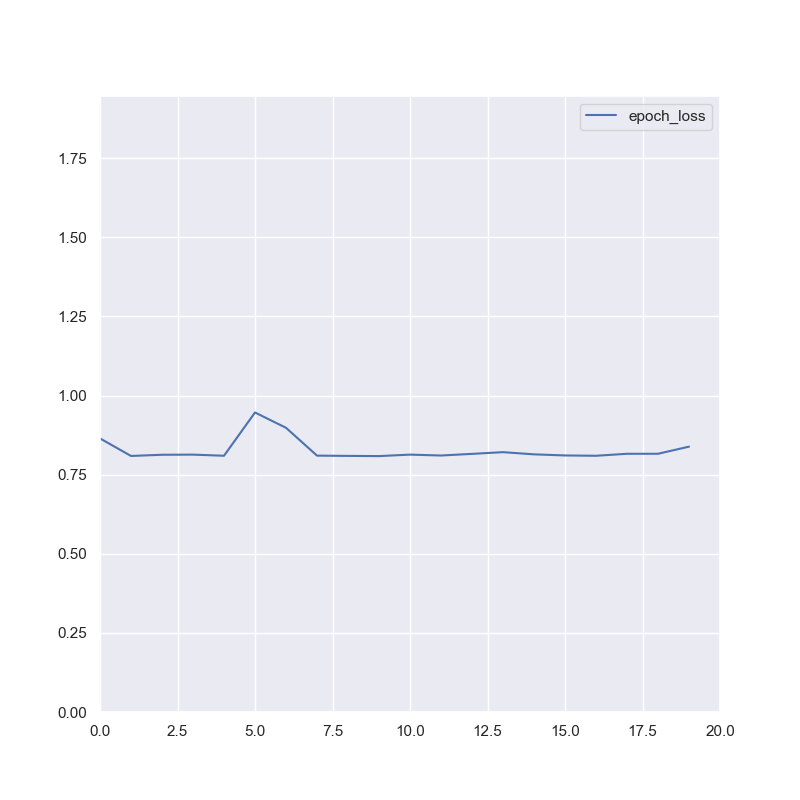

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.153288 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.864424 

Epoch 2
-------------------------------
loss: 0.620788 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.809015 

Epoch 3
-------------------------------
loss: 0.334356 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.812788 

Epoch 4
-------------------------------
loss: 1.553615 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.813234 

Epoch 5
-------------------------------
loss: 0.461763 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.809643 

Epoch 6
-------------------------------
loss: 0.420214 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.946385 

Epoch 7
-------------------------------
loss: 2.297012 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.898011 

Epoch 8
-------------------------------
loss: 1.059504 [    0/  184]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.810067 

Epoch 9
------------------------

In [16]:
plt.ion()
run_training(20)